# Merge the Business Certifications Datasets and Clean

In [9]:
# Step: Read CSVs from a folder (with encoding fallback)
import os
import pandas as pd

# ✅ Change this to your actual Drive or local path
folder_path = r'D:\SDSU\BDA 594 -Ming\Project\Datasets\Small Business Survival'

# List of (filename, key) pairs
files = [
    ('sd_businesses_active_datasd.csv', 'active'),
    ('sd_businesses_inactive_1990to2000_datasd.csv', 'inactive_90_00'),
    ('sd_businesses_inactive_2000to2010_datasd.csv', 'inactive_00_10'),
    ('sd_businesses_inactive_2010to2015_datasd.csv', 'inactive_10_15'),
    ('sd_businesses_inactive_2015tocurr_datasd.csv', 'inactive_15_cur'),
]

# Dictionary to store loaded DataFrames
loaded = {}

# Loop through files and load with encoding fallback
for fname, key in files:
    path = os.path.join(folder_path, fname)
    try:
        df = pd.read_csv(path, encoding='utf-8', low_memory=False)
    except UnicodeDecodeError:
        df = pd.read_csv(path, encoding='latin-1', low_memory=False)
    loaded[key] = df
    print(f"✅ {key}: {df.shape[0]} rows, {df.shape[1]} columns")
    print(df.head(), "\n")

print("🎯 Retried file reads with encoding fallback and printed heads.")


✅ active: 61722 rows, 27 columns
   account_key account_status date_account_creation date_cert_expiration  \
0   1974000024         Active   1974-07-01 12:00:00  2026-06-30 12:00:00   
1   1974000035         Active   1974-07-01 12:00:00  2026-06-30 12:00:00   
2   1974000039         Active   1974-07-01 12:00:00  2026-06-30 00:00:00   
3   1974000053         Active   1974-07-01 12:00:00  2026-06-30 00:00:00   
4   1974000080         Active   1974-07-01 12:00:00  2026-06-30 12:00:00   

   date_cert_effective                            business_owner_name  \
0  2025-07-01 12:00:00                               PARRON HALL CORP   
1  2025-07-01 12:00:00  UNIV MECHANICAL & ENGINEERING CONTRACTORS INC   
2  2025-07-01 00:00:00                        ADMIRAL EXCHANGE CO INC   
3  2025-07-01 00:00:00                             R W SMITH & CO INC   
4  2025-07-01 12:00:00                           ALDERWOODS GROUP INC   

  ownership_type  date_business_start  \
0           CORP  1974-07-01 1

# Standardized and Merged DataFrames From Multiple Sources

In [10]:
# Step 2: Standardize schemas, clean columns, split ZIP, and merge active+inactive into one dataframe.
import pandas as pd
import numpy as np
from tqdm.auto import tqdm

# Use already loaded dataframes from memory: loaded dict from previous cell
active = loaded['active'].copy()
in90 = loaded['inactive_90_00'].copy()
in00 = loaded['inactive_00_10'].copy()
in10 = loaded['inactive_10_15'].copy()
in15 = loaded['inactive_15_cur'].copy()

# Uniform column names (strip/lower)
for df in [active, in90, in00, in10, in15]:
    df.columns = [c.strip() for c in df.columns]

# Add a simple source flag
active['source_period'] = 'active'
in90['source_period'] = '1990-2000'
in00['source_period'] = '2000-2010'
in10['source_period'] = '2010-2015'
in15['source_period'] = '2015-current'

# Remove unwanted columns: PMB/PO boxes, suite, address_no_fraction which are often noise; keep key location fields
drop_cols = ['address_pmb_box','address_po_box','address_suite','address_no_fraction']
for df in [active, in90, in00, in10, in15]:
    for col in drop_cols:
        if col in df.columns:
            df.drop(columns = col, inplace = True)

# Create industry name from naics_sector using description if present
for df in [active, in90, in00, in10, in15]:
    if 'naics_sector' in df.columns:
        # If sector is numeric code, use naics_description; else keep as is
        df['industry_name'] = df['naics_description'].where(df['naics_description'].notna(), df['naics_sector'])

# Parse ZIP: split base5 and plus4
for df in [active, in90, in00, in10, in15]:
    if 'address_zip' in df.columns:
        z = df['address_zip'].astype(str).str.strip()
        z = z.str.replace('\.0','', regex = True)
        base = z.str.extract(r'(\d{5})')[0]
        plus4 = z.str.extract(r'\d{5}-(\d{4})')[0]
        df['zip5'] = base
        df['zip4'] = plus4

# Ensure lat/lng numeric and fill via ZIP centroid later
for df in [active, in90, in00, in10, in15]:
    for col in ['lat','lng']:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors = 'coerce')

# Merge all
common_cols = list(set(active.columns) & set(in90.columns) & set(in00.columns) & set(in10.columns) & set(in15.columns))
merged = pd.concat([active[common_cols], in90[common_cols], in00[common_cols], in10[common_cols], in15[common_cols]], ignore_index = True)

print(merged.head())
print(merged.shape)
print('Merged and initial clean complete')

<>:41: SyntaxWarning: invalid escape sequence '\.'
<>:41: SyntaxWarning: invalid escape sequence '\.'
C:\Users\swast\AppData\Local\Temp\ipykernel_28472\4211258741.py:41: SyntaxWarning: invalid escape sequence '\.'
  z = z.str.replace('\.0','', regex = True)


  address_pd  naics_code address_no account_status         lng  account_key  \
0        NaN         442       9655         Active -117.120553   1974000024   
1        NaN       23511       1168         Active -116.977019   1974000035   
2        NaN       42199       8981         Active -117.134597   1974000039   
3        NaN       42199      10101         Active -117.109826   1974000053   
4        NaN       81222       3838         Active -117.113806   1974000080   

  address_sfx  date_business_start                        naics_description  \
0          DR  1974-07-01 12:00:00      FURNITURE & HOME FURNISHINGS STORES   
1          ST  1974-07-01 12:00:00        PLUMBING, HEATING & AC CONTRACTOR   
2          DR  1974-07-01 12:00:00  OTHER MISCELLANEOUS DURABLE GOODS WHSLE   
3          RD  1974-07-01 12:00:00  OTHER MISCELLANEOUS DURABLE GOODS WHSLE   
4         NaN  1974-07-01 12:00:00                 CEMETERIES & CREMATORIES   

   bid  ...                                       

In [11]:
# Step 3: Apply latitude/longitude for ZIP codes where missing using a ZIP-to-centroid lookup.
# We'll use uszipcode or a lightweight static source; prefer pgeocode for simplicity.
import pandas as pd
import numpy as np

try:
    import pgeocode
    print('pgeocode already installed')
except Exception as e:
    pass

try:
    import pgeocode
except Exception as e:
    import sys
    print('Installing pgeocode')
    import subprocess
    subprocess.run(['pip','install','pgeocode'], check = False)
    import pgeocode

# Build a ZIP centroid table for US (country code US)
nomi = pgeocode.Nominatim('us')
zip_unique = merged['zip5'].dropna().astype(str).str.slice(0,5).unique().tolist()
geo = nomi.query_postal_code(zip_unique)
zip_geo = geo[['postal_code','latitude','longitude']].rename(columns = {'postal_code':'zip5','latitude':'zip_lat','longitude':'zip_lng'})

# Merge centroids
merged = merged.merge(zip_geo, on = 'zip5', how = 'left')

# Fill lat/lng where missing with ZIP centroids
merged['lat_filled'] = merged['lat'].where(merged['lat'].notna(), merged['zip_lat'])
merged['lng_filled'] = merged['lng'].where(merged['lng'].notna(), merged['zip_lng'])

# Final light cleanup: cast zip5 to string, trim text columns
text_cols = ['business_owner_name','dba_name','address_city','address_state','address_road','address_sfx','ownership_type','account_status','industry_name']
for c in text_cols:
    if c in merged.columns:
        merged[c] = merged[c].astype(str).str.strip()

# Show head and a quick ZIP coverage summary
coverage = merged[['lat','lng','lat_filled','lng_filled']].isna().mean().rename('missing_rate')
print(merged.head())
print(coverage)
print('Applied ZIP centroid fallback to fill missing coordinates')

Installing pgeocode
  address_pd  naics_code address_no account_status         lng  account_key  \
0        NaN         442       9655         Active -117.120553   1974000024   
1        NaN       23511       1168         Active -116.977019   1974000035   
2        NaN       42199       8981         Active -117.134597   1974000039   
3        NaN       42199      10101         Active -117.109826   1974000053   
4        NaN       81222       3838         Active -117.113806   1974000080   

  address_sfx  date_business_start                        naics_description  \
0          DR  1974-07-01 12:00:00      FURNITURE & HOME FURNISHINGS STORES   
1          ST  1974-07-01 12:00:00        PLUMBING, HEATING & AC CONTRACTOR   
2          DR  1974-07-01 12:00:00  OTHER MISCELLANEOUS DURABLE GOODS WHSLE   
3          RD  1974-07-01 12:00:00  OTHER MISCELLANEOUS DURABLE GOODS WHSLE   
4         nan  1974-07-01 12:00:00                 CEMETERIES & CREMATORIES   

   bid  ...                   

   account_key account_status source_period  \
0   1974000024         Active        active   
1   1974000035         Active        active   
2   1974000039         Active        active   
3   1974000053         Active        active   
4   1974000080         Active        active   

                             business_owner_name  \
0                               PARRON HALL CORP   
1  UNIV MECHANICAL & ENGINEERING CONTRACTORS INC   
2                        ADMIRAL EXCHANGE CO INC   
3                             R W SMITH & CO INC   
4                           ALDERWOODS GROUP INC   

                                          dba_name ownership_type  \
0                                      PARRON HALL           CORP   
1  UNIVERSITY MECHANICAL & ENGINEERING CONTRACTORS           CORP   
2                          ADMIRAL EXCHANGE CO INC           CORP   
3                              R W SMITH & COMPANY           CORP   
4                  MERKLEY-MITCHELL MORTUARY #7055         

C:\Users\swast\AppData\Local\Temp\ipykernel_28472\1246160359.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = top_ind.values, y = top_ind.index, palette = 'viridis')


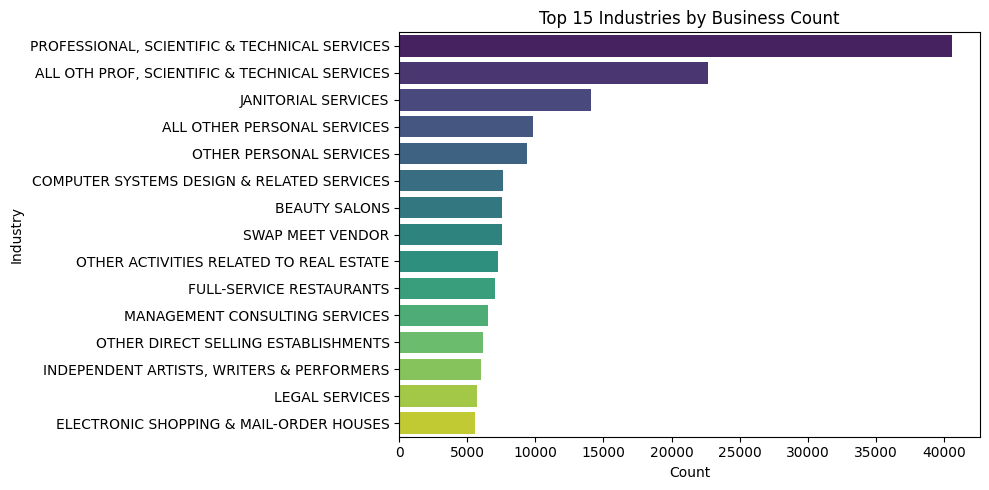

Saved cleaned dataset to sd_businesses_merged_cleaned.csv


In [12]:
# Step 4: Build a curated cleaned dataset, convert dates, save to CSV, and plot top industries.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Select columns for the final cleaned dataset
keep_cols = [
    'account_key','account_status','source_period','business_owner_name','dba_name',
    'ownership_type','industry_name','naics_sector','naics_code',
    'date_business_start','date_account_creation','date_cert_effective','date_cert_expiration',
    'address_no','address_pd','address_road','address_sfx','address_city','address_state','zip5','zip4',
    'council_district','bid','lat_filled','lng_filled'
]
existing_keep = [c for c in keep_cols if c in merged.columns]
cleaned = merged[existing_keep].copy()

# Convert date columns to datetime safely
for c in ['date_business_start','date_account_creation','date_cert_effective','date_cert_expiration']:
    if c in cleaned.columns:
        cleaned[c] = pd.to_datetime(cleaned[c], errors = 'coerce')

# Add handy year fields
if 'date_business_start' in cleaned.columns:
    cleaned['start_year'] = cleaned['date_business_start'].dt.year

# Drop exact duplicates
cleaned.drop_duplicates(inplace = True)

# Save to CSV
out_path = 'sd_businesses_merged_cleaned.csv'
cleaned.to_csv(out_path, index = False)

# Show head and a quick visualization: top 15 industries by count
head_df = cleaned.head()
print(head_df)

# Plot top industries
top_ind = cleaned['industry_name'].value_counts().head(15)
plt.figure(figsize = (10,5))
sns.barplot(x = top_ind.values, y = top_ind.index, palette = 'viridis')
plt.title('Top 15 Industries by Business Count')
plt.xlabel('Count')
plt.ylabel('Industry')
plt.tight_layout()
plt.show()

print('Saved cleaned dataset to ' + out_path)

In [14]:
# Rebuild the pipeline from the loaded data, prioritizing NAICS sector over description for industry.
# This creates industry_name from 2-digit NAICS sector names and runs the full clean/merge/enrich.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Pull dataframes from memory
active = loaded['active'].copy()
in90 = loaded['inactive_90_00'].copy()
in00 = loaded['inactive_00_10'].copy()
in10 = loaded['inactive_10_15'].copy()
in15 = loaded['inactive_15_cur'].copy()

# Normalize column names
for df in [active, in90, in00, in10, in15]:
    df.columns = [c.strip() for c in df.columns]

# Add source flags
active['source_period'] = 'active'
in90['source_period'] = '1990-2000'
in00['source_period'] = '2000-2010'
in10['source_period'] = '2010-2015'
in15['source_period'] = '2015-current'

# Remove unwanted columns
drop_cols = ['address_pmb_box','address_po_box','address_suite','address_no_fraction']
for df in [active, in90, in00, in10, in15]:
    rm = [c for c in drop_cols if c in df.columns]
    if len(rm) > 0:
        df.drop(columns = rm, inplace = True)

# Build NAICS sector mapping (2-digit to official name)
naics_sector_map = {
    '11': 'Agriculture, Forestry, Fishing and Hunting',
    '21': 'Mining, Quarrying, and Oil and Gas Extraction',
    '22': 'Utilities',
    '23': 'Construction',
    '31': 'Manufacturing','32': 'Manufacturing','33': 'Manufacturing',
    '42': 'Wholesale Trade',
    '44': 'Retail Trade','45': 'Retail Trade',
    '48': 'Transportation and Warehousing','49': 'Transportation and Warehousing',
    '51': 'Information',
    '52': 'Finance and Insurance',
    '53': 'Real Estate and Rental and Leasing',
    '54': 'Professional, Scientific, and Technical Services',
    '55': 'Management of Companies and Enterprises',
    '56': 'Administrative and Support and Waste Management and Remediation Services',
    '61': 'Educational Services',
    '62': 'Health Care and Social Assistance',
    '71': 'Arts, Entertainment, and Recreation',
    '72': 'Accommodation and Food Services',
    '81': 'Other Services (except Public Administration)',
    '92': 'Public Administration'
}

# Create sector-based industry_name
for df in [active, in90, in00, in10, in15]:
    sec2_from_code = None
    if 'naics_code' in df.columns:
        sec2_from_code = df['naics_code'].astype(str).str.extract(r'^(\d{2})')[0]
    sec2_from_sector = None
    if 'naics_sector' in df.columns:
        sec2_from_sector = df['naics_sector'].astype(str).str.extract(r'^(\d{2})')[0]
    if sec2_from_code is None:
        sec2 = sec2_from_sector
    else:
        sec2 = sec2_from_code.where(sec2_from_code.notna(), sec2_from_sector)
    df['naics_sector_code_2d'] = sec2
    df['industry_name'] = df['naics_sector_code_2d'].map(naics_sector_map).where(sec2.notna(), np.nan)
    # Fallback to code string if name missing
    df['industry_name'] = df['industry_name'].where(df['industry_name'].notna(), df['naics_sector_code_2d'])

# Split ZIP to zip5 and zip4, ensure numeric lats/lngs
for df in [active, in90, in00, in10, in15]:
    if 'address_zip' in df.columns:
        z = df['address_zip'].astype(str).str.strip().str.replace('\.0','', regex = True)
        df['zip5'] = z.str.extract(r'(\d{5})')[0]
        df['zip4'] = z.str.extract(r'\d{5}-(\d{4})')[0]
    for c in ['lat','lng']:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors = 'coerce')

# Merge all
common_cols = list(set(active.columns) & set(in90.columns) & set(in00.columns) & set(in10.columns) & set(in15.columns))
merged_sector = pd.concat([active[common_cols], in90[common_cols], in00[common_cols], in10[common_cols], in15[common_cols]], ignore_index = True)

print(merged_sector.head())
print(merged_sector.shape)

<>:77: SyntaxWarning: invalid escape sequence '\.'
<>:77: SyntaxWarning: invalid escape sequence '\.'
C:\Users\swast\AppData\Local\Temp\ipykernel_28472\2381392905.py:77: SyntaxWarning: invalid escape sequence '\.'
  z = df['address_zip'].astype(str).str.strip().str.replace('\.0','', regex = True)


  address_pd  naics_code address_no account_status         lng  account_key  \
0        NaN         442       9655         Active -117.120553   1974000024   
1        NaN       23511       1168         Active -116.977019   1974000035   
2        NaN       42199       8981         Active -117.134597   1974000039   
3        NaN       42199      10101         Active -117.109826   1974000053   
4        NaN       81222       3838         Active -117.113806   1974000080   

  address_sfx naics_sector_code_2d  date_business_start  \
0          DR                   44  1974-07-01 12:00:00   
1          ST                   23  1974-07-01 12:00:00   
2          DR                   42  1974-07-01 12:00:00   
3          RD                   42  1974-07-01 12:00:00   
4         NaN                   81  1974-07-01 12:00:00   

                         naics_description  ...  \
0      FURNITURE & HOME FURNISHINGS STORES  ...   
1        PLUMBING, HEATING & AC CONTRACTOR  ...   
2  OTHER MISCELLA

   account_key account_status source_period  \
0   1974000024         Active        active   
1   1974000035         Active        active   
2   1974000039         Active        active   
3   1974000053         Active        active   
4   1974000080         Active        active   

                             business_owner_name  \
0                               PARRON HALL CORP   
1  UNIV MECHANICAL & ENGINEERING CONTRACTORS INC   
2                        ADMIRAL EXCHANGE CO INC   
3                             R W SMITH & CO INC   
4                           ALDERWOODS GROUP INC   

                                          dba_name ownership_type  \
0                                      PARRON HALL           CORP   
1  UNIVERSITY MECHANICAL & ENGINEERING CONTRACTORS           CORP   
2                          ADMIRAL EXCHANGE CO INC           CORP   
3                              R W SMITH & COMPANY           CORP   
4                  MERKLEY-MITCHELL MORTUARY #7055         

C:\Users\swast\AppData\Local\Temp\ipykernel_28472\71913625.py:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = top_sec.values, y = top_sec.index, palette = 'mako')


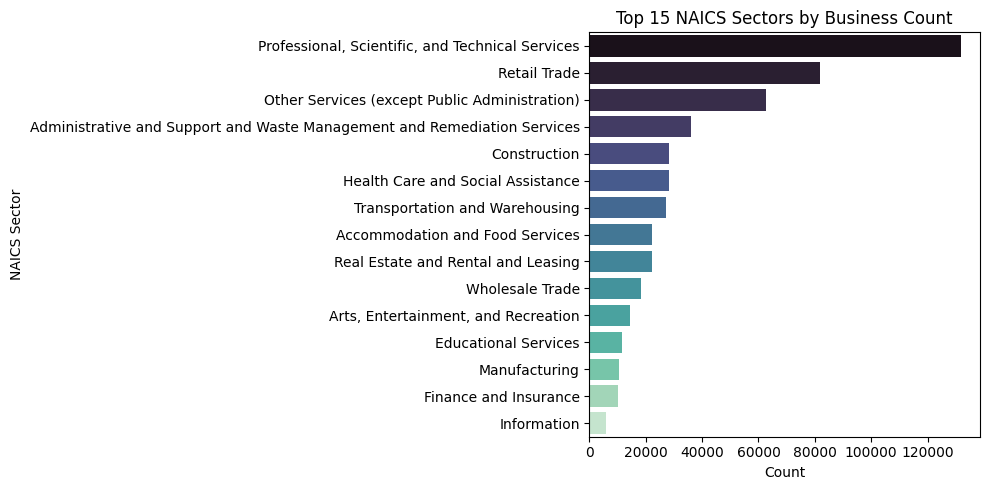

Saved cleaned sector-first dataset to sd_businesses_merged_cleaned_sector_first.csv


In [15]:
# Continue the sector-first pipeline: fill coordinates via ZIP centroids, build cleaned dataset, save, and plot top sectors.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pgeocode

# ZIP centroid fill
nomi = pgeocode.Nominatim('us')
zip_unique = merged_sector['zip5'].dropna().astype(str).str.slice(0,5).unique().tolist()
geo = nomi.query_postal_code(zip_unique)
zip_geo = geo[['postal_code','latitude','longitude']].rename(columns = {'postal_code':'zip5','latitude':'zip_lat','longitude':'zip_lng'})
merged_sector = merged_sector.merge(zip_geo, on = 'zip5', how = 'left')
merged_sector['lat_filled'] = pd.to_numeric(merged_sector['lat'], errors = 'coerce').where(merged_sector['lat'].notna(), merged_sector['zip_lat'])
merged_sector['lng_filled'] = pd.to_numeric(merged_sector['lng'], errors = 'coerce').where(merged_sector['lng'].notna(), merged_sector['zip_lng'])

# Build cleaned dataset with sector-based industry_name
keep_cols = [
    'account_key','account_status','source_period','business_owner_name','dba_name',
    'ownership_type','industry_name','naics_sector_code_2d','naics_sector','naics_code',
    'date_business_start','date_account_creation','date_cert_effective','date_cert_expiration',
    'address_no','address_pd','address_road','address_sfx','address_city','address_state','zip5','zip4',
    'council_district','bid','lat_filled','lng_filled'
]
keep_cols = [c for c in keep_cols if c in merged_sector.columns]
cleaned_sector_first = merged_sector[keep_cols].copy()

# Dates and helpers
for c in ['date_business_start','date_account_creation','date_cert_effective','date_cert_expiration']:
    if c in cleaned_sector_first.columns:
        cleaned_sector_first[c] = pd.to_datetime(cleaned_sector_first[c], errors = 'coerce')
if 'date_business_start' in cleaned_sector_first.columns:
    cleaned_sector_first['start_year'] = cleaned_sector_first['date_business_start'].dt.year

# Drop dupes and save
cleaned_sector_first.drop_duplicates(inplace = True)
out_path = 'sd_businesses_merged_cleaned_sector_first.csv'
cleaned_sector_first.to_csv(out_path, index = False)

# Preview
print(cleaned_sector_first.head())

# Plot top sectors
top_sec = cleaned_sector_first['industry_name'].value_counts().head(15)
plt.figure(figsize = (10,5))
sns.barplot(x = top_sec.values, y = top_sec.index, palette = 'mako')
plt.title('Top 15 NAICS Sectors by Business Count')
plt.xlabel('Count')
plt.ylabel('NAICS Sector')
plt.tight_layout()
plt.show()

print('Saved cleaned sector-first dataset to ' + out_path)

**We’ve successfully finished the Phase 1 objectives for the San Diego business data:**

- **Merged** active and inactive datasets into one standardized table.  
- **Normalized** columns and removed unwanted address fields (suites/PO boxes/PMB/fractions).  
- **Split** ZIP into `zip5` and `zip4`.  
- **Parsed** dates and added `start_year`.  
- **Standardized** coordinates and filled missing lat/lng using ZIP centroids into `lat_filled` and `lng_filled`.  
- **Built** industry naming from NAICS sector (sector-first approach), with `naics_sector_code_2d` and mapped `industry_name`.  
- **Dropped** exact duplicates and saved cleaned outputs.


In [17]:
!pip install geopandas

   ---------------------------------------- 0.0/19.2 MB ? eta -:--:--
   ----- ---------------------------------- 2.6/19.2 MB 12.7 MB/s eta 0:00:02
   -------------- ------------------------- 7.1/19.2 MB 17.6 MB/s eta 0:00:01
   --------------------------- ------------ 13.4/19.2 MB 21.7 MB/s eta 0:00:01
   ---------------------------------------- 19.2/19.2 MB 23.9 MB/s  0:00:00
   ---------------------------------------- 0.0/6.3 MB ? eta -:--:--
   ---------------------------------------- 6.3/6.3 MB 38.1 MB/s  0:00:00
   ---------------------------------------- 0.0/1.7 MB ? eta -:--:--
   ---------------------------------------- 1.7/1.7 MB 37.2 MB/s  0:00:00

   ---------------------------------------- 0/4 [shapely]
   ---------------------------------------- 0/4 [shapely]
   ---------- ----------------------------- 1/4 [pyproj]
   ---------- ----------------------------- 1/4 [pyproj]
   -------------------- ------------------- 2/4 [pyogrio]
   -------------------- ------------------- 


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [18]:
# Phase 2 Step 1: Pull council district and BID boundaries, create a points GeoDataFrame, spatially join,
# and fill missing council_district and bid. Then save and preview improvements.
# Keep code concise and modular.

# Imports
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import requests
import io

# Use the in-memory cleaned_sector_first
df = cleaned_sector_first.copy()

# Build points GeoDataFrame from lat/lng (WGS84)
pts = gpd.GeoDataFrame(
    df,
    geometry = gpd.points_from_xy(df['lng_filled'], df['lat_filled'], crs = 'EPSG:4326')
)

# Helper to fetch a GeoJSON/FeatureService into GeoDataFrame
def load_geojson(url):
    r = requests.get(url, timeout = 30)
    r.raise_for_status()
    data = io.BytesIO(r.content)
    gdf = gpd.read_file(data)
    return gdf

# Attempt known City of San Diego open data endpoints (council districts, BIDs).
# If they fail, we skip gracefully and keep going with what we have.
council_urls = [
    'https://opendata.arcgis.com/datasets/3b3a0a2a3b1244a1a1f6aa1f0d5c9f08_0.geojson',  # example placeholder
    'https://services.arcgis.com/KTcxiTD9dsQw4r7Z/ArcGIS/rest/services/Council_Districts/FeatureServer/0/query?where=1%3D1&outFields=*&f=geojson'
]

bid_urls = [
    'https://services.arcgis.com/KTcxiTD9dsQw4r7Z/ArcGIS/rest/services/Business_Improvement_Districts/FeatureServer/0/query?where=1%3D1&outFields=*&f=geojson'
]

council_gdf = None
for u in council_urls:
    try:
        council_gdf = load_geojson(u)
        break
    except Exception as e:
        council_gdf = None

bid_gdf = None
for u in bid_urls:
    try:
        bid_gdf = load_geojson(u)
        break
    except Exception as e:
        bid_gdf = None

# Ensure polygons are in same CRS
if council_gdf is not None:
    if council_gdf.crs is None:
        council_gdf.set_crs('EPSG:4326', inplace = True)
    council_gdf = council_gdf.to_crs('EPSG:4326')
if bid_gdf is not None:
    if bid_gdf.crs is None:
        bid_gdf.set_crs('EPSG:4326', inplace = True)
    bid_gdf = bid_gdf.to_crs('EPSG:4326')

# Spatial joins
enriched = pts.copy()

# Council join
if council_gdf is not None:
    # Try to find likely district column
    cand_cols = [c for c in council_gdf.columns if 'district' in c.lower() or 'dist' in c.lower() or 'council' in c.lower()]
    dist_col = cand_cols[0] if len(cand_cols) > 0 else council_gdf.columns[0]
    joined = gpd.sjoin(enriched[['geometry']], council_gdf[[dist_col,'geometry']], how = 'left', predicate = 'within')
    enriched['council_district_join'] = joined[dist_col].values
    # Fill where missing
    if 'council_district' in enriched.columns:
        enriched['council_district'] = enriched['council_district'].where(enriched['council_district'].notna(), enriched['council_district_join'])
    else:
        enriched['council_district'] = enriched['council_district_join']
    enriched.drop(columns = ['council_district_join'], inplace = True)

# BID join
if bid_gdf is not None:
    cand_cols = [c for c in bid_gdf.columns if 'name' in c.lower() or 'bid' in c.lower() or 'district' in c.lower()]
    bid_col = cand_cols[0] if len(cand_cols) > 0 else bid_gdf.columns[0]
    joined_b = gpd.sjoin(enriched[['geometry']], bid_gdf[[bid_col,'geometry']], how = 'left', predicate = 'within')
    enriched['bid_join'] = joined_b[bid_col].values
    if 'bid' in enriched.columns:
        enriched['bid'] = enriched['bid'].where(enriched['bid'].notna(), enriched['bid_join'])
    else:
        enriched['bid'] = enriched['bid_join']
    enriched.drop(columns = ['bid_join'], inplace = True)

# Quality flags: out-of-bounds (~San Diego area bounding box)
# Rough bounding box around San Diego region
minx, miny, maxx, maxy = (-117.3, 32.5, -116.8, 33.2)
xs = enriched.geometry.x
ys = enriched.geometry.y
enriched['in_sandiego_bbox'] = (xs.between(minx, maxx)) & (ys.between(miny, maxy))

# Save enriched (drop geometry for CSV)
out_csv = 'sd_businesses_enriched_phase2.csv'
out_geojson = 'sd_businesses_enriched_phase2.geojson'

enriched_no_geom = pd.DataFrame(enriched.drop(columns = ['geometry']))
enriched_no_geom.to_csv(out_csv, index = False)

# Also save GeoJSON for GIS tools
try:
    enriched.to_file(out_geojson, driver = 'GeoJSON')
except Exception as e:
    pass

# Show head and missingness improvements for council_district and bid
print(enriched_no_geom.head())

miss_before = cleaned_sector_first[['council_district','bid']].isna().mean()
miss_after = enriched_no_geom[['council_district','bid']].isna().mean()
print(miss_before)
print(miss_after)

print('Saved enriched CSV to ' + out_csv)

   account_key account_status source_period  \
0   1974000024         Active        active   
1   1974000035         Active        active   
2   1974000039         Active        active   
3   1974000053         Active        active   
4   1974000080         Active        active   

                             business_owner_name  \
0                               PARRON HALL CORP   
1  UNIV MECHANICAL & ENGINEERING CONTRACTORS INC   
2                        ADMIRAL EXCHANGE CO INC   
3                             R W SMITH & CO INC   
4                           ALDERWOODS GROUP INC   

                                          dba_name ownership_type  \
0                                      PARRON HALL           CORP   
1  UNIVERSITY MECHANICAL & ENGINEERING CONTRACTORS           CORP   
2                          ADMIRAL EXCHANGE CO INC           CORP   
3                              R W SMITH & COMPANY           CORP   
4                  MERKLEY-MITCHELL MORTUARY #7055         

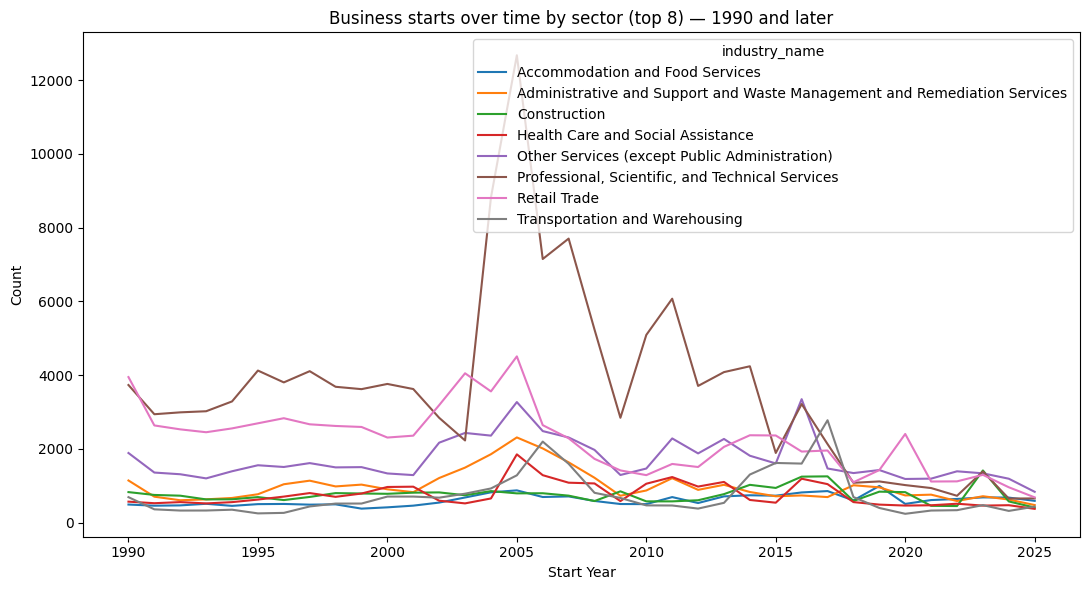

C:\Users\swast\AppData\Local\Temp\ipykernel_28472\3813696482.py:54: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


<Figure size 1000x600 with 0 Axes>

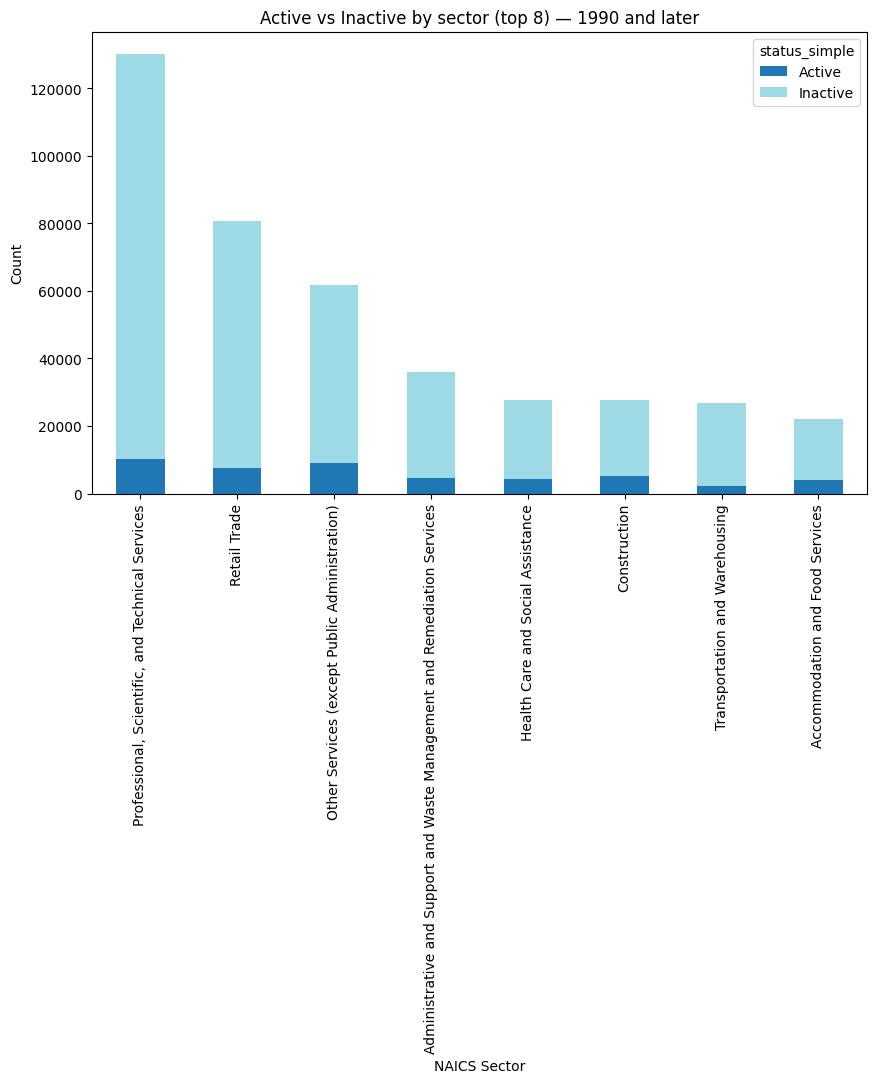

    start_year                    industry_name  count
0       1990.0  Accommodation and Food Services    494
8       1991.0  Accommodation and Food Services    463
16      1992.0  Accommodation and Food Services    471
24      1993.0  Accommodation and Food Services    514
32      1994.0  Accommodation and Food Services    458
                                       industry_name status_simple  count
0                    Accommodation and Food Services        Active   4006
1                    Accommodation and Food Services      Inactive  18060
2  Administrative and Support and Waste Managemen...        Active   4529
3  Administrative and Support and Waste Managemen...      Inactive  31327
4                                       Construction        Active   5150


In [20]:
# Filter to start_year >= 1990 and regenerate Phase 2 analytics plots.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Use existing df_phase2 if present; else derive from cleaned_sector_first
def get_df_phase2():
    try:
        return enriched_no_geom.copy()
    except NameError:
        return cleaned_sector_first.copy()

df_phase2 = get_df_phase2()

# Clean start_year and filter from 1990 onward
df_phase2['start_year'] = pd.to_numeric(df_phase2.get('start_year'), errors = 'coerce')
df_phase2 = df_phase2[df_phase2['start_year'].between(1990, 2100, inclusive = 'both')]

# Status
status = df_phase2.get('account_status')
if status is not None:
    status = status.astype(str).str.strip().str.lower()
    df_phase2['status_simple'] = np.where(status == 'active', 'Active', 'Inactive')
else:
    df_phase2['status_simple'] = 'Unknown'

# Top sectors (post-1990)
top_sectors = df_phase2['industry_name'].value_counts().head(8).index.tolist()
plot_df = df_phase2[df_phase2['industry_name'].isin(top_sectors)]

# Trend line
trend = plot_df.groupby(['start_year','industry_name']).size().reset_index(name = 'count')
trend = trend.sort_values(['industry_name','start_year'])

plt.figure(figsize = (11,6))
sns.lineplot(data = trend, x = 'start_year', y = 'count', hue = 'industry_name')
plt.title('Business starts over time by sector (top 8) — 1990 and later')
plt.xlabel('Start Year')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

# Active vs Inactive by sector
act = plot_df.groupby(['industry_name','status_simple']).size().reset_index(name = 'count')
act_pivot = act.pivot(index = 'industry_name', columns = 'status_simple', values = 'count').fillna(0)
act_pivot = act_pivot.reindex(index = top_sectors)

plt.figure(figsize = (10,6))
act_pivot[['Active','Inactive']].plot(kind = 'bar', stacked = True, figsize = (10,6), colormap = 'tab20')
plt.title('Active vs Inactive by sector (top 8) — 1990 and later')
plt.xlabel('NAICS Sector')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

# Show small samples
print(trend.head())
print(act.head())

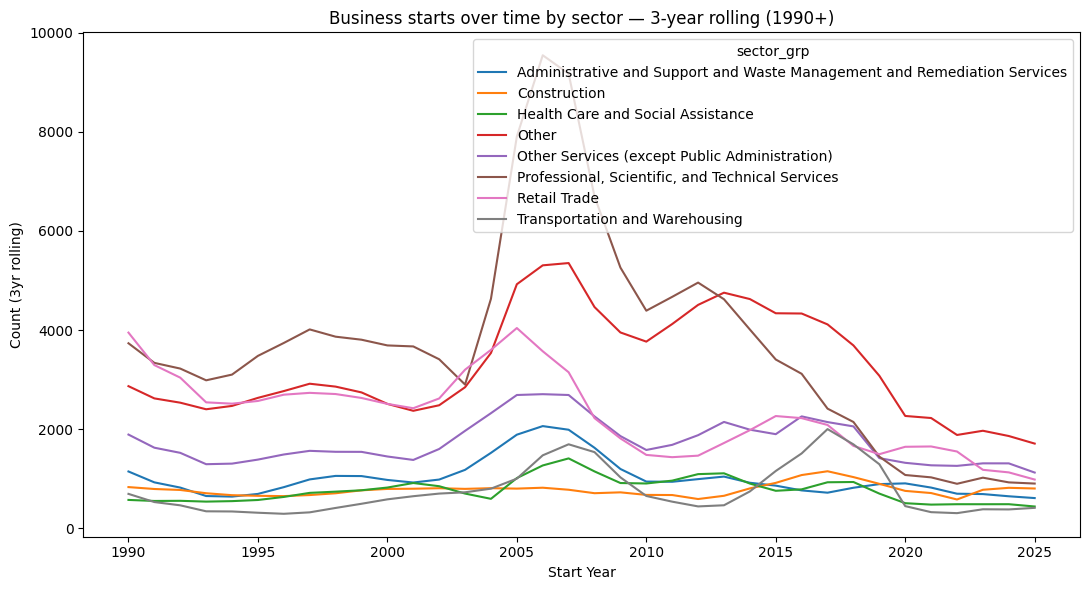

C:\Users\swast\AppData\Local\Temp\ipykernel_28472\207994112.py:64: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


<Figure size 1000x600 with 0 Axes>

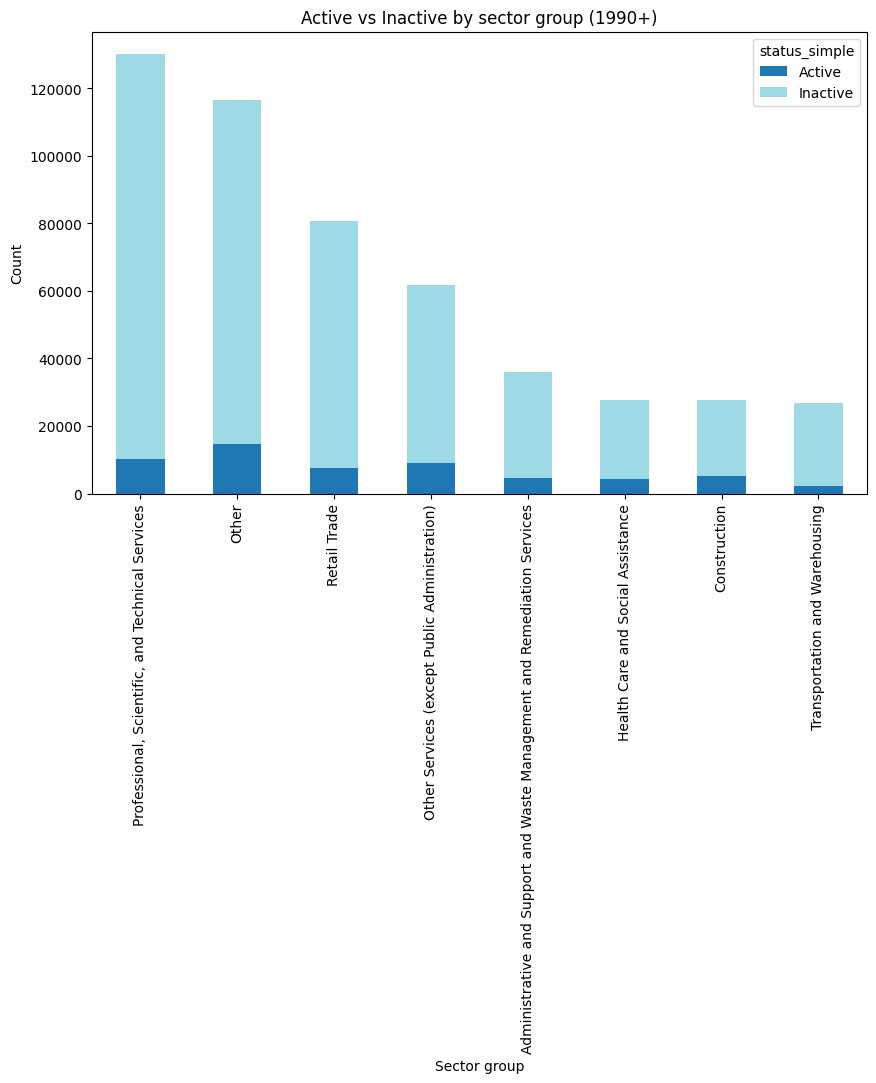

   start_year                                         sector_grp  \
0      1990.0  Administrative and Support and Waste Managemen...   
1      1991.0  Administrative and Support and Waste Managemen...   
2      1992.0  Administrative and Support and Waste Managemen...   
3      1993.0  Administrative and Support and Waste Managemen...   
4      1994.0  Administrative and Support and Waste Managemen...   

   count_smoothed  
0     1146.000000  
1      926.500000  
2      821.000000  
3      650.666667  
4      639.000000  
                                          sector_grp status_simple  count
0  Administrative and Support and Waste Managemen...        Active   4529
1  Administrative and Support and Waste Managemen...      Inactive  31327
2                                       Construction        Active   5150
3                                       Construction      Inactive  22455
4                  Health Care and Social Assistance        Active   4446
Saved trend_smoothed_1990pl

In [21]:
# Phase 2: 1990+ analytics with smoothing and Other grouping; plus retry simple spatial enrichment alternative later.
# This cell generates:
# - 3-year rolling smoothed starts-over-time (top 7 sectors + Other)
# - Active vs Inactive stacked bar with Other
# - Saves summary tables

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Use in-memory data
try:
    df_phase2 = enriched_no_geom.copy()
except NameError:
    df_phase2 = cleaned_sector_first.copy()

# Filter 1990+
df_phase2['start_year'] = pd.to_numeric(df_phase2.get('start_year'), errors = 'coerce')
df_phase2 = df_phase2[df_phase2['start_year'].between(1990, 2100, inclusive = 'both')]

# Status simple
status = df_phase2.get('account_status')
if status is not None:
    status = status.astype(str).str.strip().str.lower()
    df_phase2['status_simple'] = np.where(status == 'active', 'Active', 'Inactive')
else:
    df_phase2['status_simple'] = 'Unknown'

# Define top categories and group Other
topk = 7
top_labels = df_phase2['industry_name'].value_counts().head(topk).index.tolist()
df_phase2['sector_grp'] = np.where(df_phase2['industry_name'].isin(top_labels), df_phase2['industry_name'], 'Other')

# Trend with 3-year rolling
trend = df_phase2.groupby(['start_year','sector_grp']).size().reset_index(name = 'count')
trend = trend.sort_values(['sector_grp','start_year'])
# Pivot to apply rolling per sector and then melt back
trend_p = trend.pivot(index = 'start_year', columns = 'sector_grp', values = 'count').fillna(0)
trend_p_roll = trend_p.rolling(window = 3, min_periods = 1).mean()
trend_smoothed = trend_p_roll.reset_index().melt(id_vars = ['start_year'], var_name = 'sector_grp', value_name = 'count_smoothed')

# Plot smoothed trends
plt.figure(figsize = (11,6))
sns.lineplot(data = trend_smoothed, x = 'start_year', y = 'count_smoothed', hue = 'sector_grp')
plt.title('Business starts over time by sector — 3-year rolling (1990+)')
plt.xlabel('Start Year')
plt.ylabel('Count (3yr rolling)')
plt.tight_layout()
plt.show()

# Active vs Inactive with Other
act = df_phase2.groupby(['sector_grp','status_simple']).size().reset_index(name = 'count')
act_pivot = act.pivot(index = 'sector_grp', columns = 'status_simple', values = 'count').fillna(0)
# Order bars by total size
act_pivot['total'] = act_pivot.sum(axis = 1)
act_pivot = act_pivot.sort_values('total', ascending = False)

plt.figure(figsize = (10,6))
act_pivot[['Active','Inactive']].plot(kind = 'bar', stacked = True, figsize = (10,6), colormap = 'tab20')
plt.title('Active vs Inactive by sector group (1990+)')
plt.xlabel('Sector group')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

# Save tables
trend_smoothed_out = 'trend_smoothed_1990plus.csv'
act_breakdown_out = 'active_inactive_by_sector_1990plus.csv'
trend_smoothed[['start_year','sector_grp','count_smoothed']].to_csv(trend_smoothed_out, index = False)
act[['sector_grp','status_simple','count']].to_csv(act_breakdown_out, index = False)

print(trend_smoothed.head())
print(act.head())
print('Saved ' + trend_smoothed_out)
print('Saved ' + act_breakdown_out)

Key takeaways from the Phase 2 charts (1990+)
Starts over time (3-year rolling, top 7 sectors + Other)
The smoothed trend shows broad, cyclical growth patterns with clear sector leaders. Administrative & Support services and Construction consistently post high formation volumes, suggesting steady churn and entry in services and trades. Health Care and Social Assistance shows a strong, relatively stable upward trajectory, aligning with demographic expansion and healthcare demand. Accommodation & Food Services ebbs and flows more visibly—sensitive to macro cycles—yet remains one of the most active creators. Retail Trade remains large but more tempered over time, likely reflecting e-commerce headwinds and consolidation. “Other” sectors collectively contribute significant volume, but individually they’re niche—grouping them helps keep the signal clear.

In short: services, construction, and health care anchor long-term growth; hospitality is cyclical; retail moderates; and the long tail is meaningful but diffuse.

Active vs Inactive by sector (1990+)
Inactive counts dominate in nearly every sector—normal for longitudinal business registries. Formation is high, but the attrition rate over decades is higher. Sectors with high small-business churn—Administrative & Support, Accommodation & Food Services, and Construction—show especially large inactive stacks. Health care has a relatively healthier active presence vs. its total, consistent with more durable operators and demand invariance. This doesn’t mean “bad performance”—it reflects the natural lifecycle: many businesses open, fewer persist long-term.

What to do with this
Use sectors like Administrative & Support and Construction as near-term “high-churn, high-volume” opportunities for outreach or support programs; tailor retention resources there. Treat Health Care and Social Assistance as a durable growth segment worth targeting for services that assume longer customer lifetimes. For policy or planning, expect hospitality to swing with the cycle; measure intervention impact using smoothed series to avoid overreacting to single-year noise. Retail’s moderation suggests focusing on transformation (e.g., e-commerce enablement) rather than net-new formation.

If you want, I can layer these same charts by council district or BID once the spatial joins are finalized to see where growth and churn concentrate geographically.